# Sentiment Classification (Binary) on Imdb Review Dataset

In [9]:
# Imports

import sys
import os
import re
import numpy as np
from datetime import datetime
from bunch import Bunch
import torch
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from helpers.dataset import Dataset

glove_file = 'C:\\Workspace\\Git\\Data\\glove.6B\\glove.6B.100d.txt'
data_root = 'C:\\Workspace\\Git\\Data\\aclImdb'
categories = ['neg', 'pos']

# Load dataset
ds = Dataset(num_classes=2)
print('[{}] Loading data ...'.format(datetime.now()))
ds.load_dataset_from_dir(os.path.join(data_root, 'train'), os.path.join(data_root, 'test'), categories)

print('[{}] Building vocab and loading glove embeddings ...'.format(datetime.now()))
ds.build_vocab()
ds.load_word_embeddings(glove_file)

print('[{}] Creating X, y sequences ...'.format(datetime.now()))
ds.compute_Xy()

print('[{}] Padding X, y sequences ...'.format(datetime.now()))
ds.pad_Xy(fixed_max_len=30)

[2019-11-09 19:54:17.593910] Loading data ...
[2019-11-09 19:56:55.160706] Building vocab and loading glove embeddings ...
[2019-11-09 19:56:59.822337] Creating X, y sequences ...
[2019-11-09 19:57:01.691016] Padding X, y sequences ...


In [3]:
def print_stats(ds):

    print('Number of Raw Training records: {} examples, {} labels '.format(
        len(ds.raw_train.data), len(ds.raw_train.target)))
    print('Number of Raw Test records: {} examples, {} labels '.format(
        len(ds.raw_test.data), len(ds.raw_test.target)))
    print('Target Names:', ds.raw_train.target_names)

    print('Label distribution in Training Set')
    print(np.asarray(np.unique(ds.raw_train.target, return_counts=True)).T)
    print('Label distribution in Test Set')
    print(np.asarray(np.unique(ds.raw_test.target, return_counts=True)).T)

    print('Vocab Size: ', len(ds.vocab))
    print('shape(word_embeddings): ', ds.word_embeddings.shape)
    print('Top 5 Words in word2index map', ['{}({})'.format(w, i) for w, i in ds.word2index.items() if i <= 5])

    print('shape(X_train) = ', ds.X_train.shape, ' dtype(X_train) = ', ds.X_train.dtype)
    print('shape(y_train) = ', ds.y_train.shape, ' dtype(y_train) = ', ds.y_train.dtype)
    print('shape(X_test) = ', ds.X_test.shape, ' dtype(X_test) = ', ds.X_test.dtype)
    print('shape(y_test) = ', ds.y_test.shape, ' dtype(y_test) = ', ds.y_test.dtype)

    print('Top 5 training examples:')
    for i in range(5):
        print('[#{}]\t {}'.format(i + 1, ds.y_train[i]))
        print('\t', ds.X_train[i][:10])
        print('\t', ' '.join(ds.raw_train.data[i].split()[:30]))
        
print_stats(ds)

Number of Raw Training records: 25000 examples, 25000 labels 
Number of Raw Test records: 25000 examples, 25000 labels 
Target Names: ['neg', 'pos']
Label distribution in Training Set
[[    0 12500]
 [    1 12500]]
Label distribution in Test Set
[[    0 12500]
 [    1 12500]]
Vocab Size:  53858
shape(word_embeddings):  (46197, 100)
Top 5 Words in word2index map ['$PAD$(0)', '$UNK$(1)', 'the(2)', 'of(3)', 'to(4)', 'and(5)']
shape(X_train) =  (25000, 30)  dtype(X_train) =  int64
shape(y_train) =  (25000, 1)  dtype(y_train) =  int32
shape(X_test) =  (25000, 30)  dtype(X_test) =  int64
shape(y_test) =  (25000, 1)  dtype(y_test) =  int32
Top 5 training examples:
[#1]	 [0]
	 [4904  339 2920  339   11    2  174   65    3    2]
	 silent night deadly night is the very last of the series and like part it s unrelated to the first three except by title and the fact that it s
[#2]	 [1]
	 [    2  1072 24523     7   174   595   295    14     7   494]
	 the idea ia a very short film with a lot of info

In [4]:
maxN = min(5000, len(ds.X_train)) 
split = int(0.9 * maxN)

X_train = ds.X_train[0:split]
y_train = ds.y_train[0:split]
X_train_seqlen = ds.X_train_seqlen[0:split]

X_val = ds.X_train[split:maxN]
y_val = ds.y_train[split:maxN]
X_val_seqlen = ds.X_train_seqlen[split:maxN]

word_embeddings = ds.word_embeddings

print('Number of Training Examples: {}, Labels: {}'.format(len(X_train), len(y_train)))
print('Number of Validation Examples: {}, Labels: {}'.format(len(X_val), len(y_val)))

print('Label distribution in Training Set')
print(np.asarray(np.unique(y_train, return_counts=True)).T)
print('Label distribution in Validation Set')
print(np.asarray(np.unique(y_val, return_counts=True)).T)

Number of Training Examples: 4500, Labels: 4500
Number of Validation Examples: 500, Labels: 500
Label distribution in Training Set
[[   0 2270]
 [   1 2230]]
Label distribution in Validation Set
[[  0 245]
 [  1 255]]


In [5]:
config = Bunch()
config.vocab_size, config.embed_size = word_embeddings.shape
config.batch_size = 64
config.lr = 0.01
config.hidden_size = 50
config.num_lstm_layers = 2
config.dropout_keep = 1 # if <1 (e.g. 0.8, then loss will fluctuate every epoch, will not decrease monotonously)
config.isBidirectional = True
config.output_size = 1

In [6]:
from helpers.TextRNN import TextRNN
from helpers.evaluate import evaluate_model
import torch.optim as optim

model = TextRNN(config,  torch.from_numpy(word_embeddings).type(torch.FloatTensor))

optimizer = optim.Adam(model.parameters(), lr=config.lr)
loss_op = nn.BCELoss()  # binary cross entropy loss

model.set_optimizer(optimizer)
model.set_loss_op(loss_op)

epoch_losses = []
epoch_metrics = []

In [7]:
for epoch in range(10):
    epoch_loss = model.run_epoch(X_train, y_train, X_train_seqlen)

    accuracy1, correct1, total1 = evaluate_model(model, X_train, y_train, X_train_seqlen, config.batch_size)
    accuracy2, correct2, total2 = evaluate_model(model, X_val, y_val, X_val_seqlen, config.batch_size)

    epoch_losses.append(epoch_loss)
    epoch_metrics.append('Training: {:.3f}% (={}/{}), Validation: {:.3f}% (={}/{})'.format(accuracy1, correct1, total1, accuracy2, correct2, total2))
    print('Epoch: {}, Loss: {}, {}'.format(epoch+1, epoch_losses[-1], epoch_metrics[-1]))

Epoch: 1, Loss: 0.6960972760404859, Training: 56.800% (=2556/4500), Validation: 46.000% (=230/500)
Epoch: 2, Loss: 0.6842866701739175, Training: 63.800% (=2871/4500), Validation: 48.000% (=240/500)
Epoch: 3, Loss: 0.6413776942661831, Training: 72.889% (=3280/4500), Validation: 47.400% (=237/500)
Epoch: 4, Loss: 0.5374668100050517, Training: 79.222% (=3565/4500), Validation: 48.000% (=240/500)
Epoch: 5, Loss: 0.45326635496956963, Training: 84.022% (=3781/4500), Validation: 45.000% (=225/500)
Epoch: 6, Loss: 0.35952339938708716, Training: 86.711% (=3902/4500), Validation: 47.200% (=236/500)
Epoch: 7, Loss: 0.2837595888546535, Training: 91.178% (=4103/4500), Validation: 48.200% (=241/500)
Epoch: 8, Loss: 0.2046896280986922, Training: 93.933% (=4227/4500), Validation: 49.400% (=247/500)
Epoch: 9, Loss: 0.17219929280025617, Training: 96.000% (=4320/4500), Validation: 51.800% (=259/500)
Epoch: 10, Loss: 0.13121933309095246, Training: 97.578% (=4391/4500), Validation: 47.200% (=236/500)


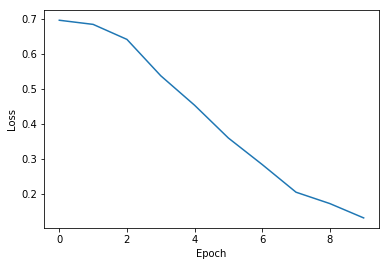

In [10]:
plt.plot(epoch_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()